# Solving the MNIST Challenge with PyTorch

![MNIST](imgs/01.mninst-intro.png)

## MNIST Dataset

The MNIST dataset is one of the most well-known benchmarks in the field of machine learning and deep learning. It consists of:
- **70,000 grayscale images** of handwritten digits (0-9).
- Each image is **28x28 pixels**, making it small and computationally efficient.
- **Labels (0 to 9)** corresponding to the digit in the image.

Originally derived from the NIST (National Institute of Standards and Technology) dataset, MNIST was curated and processed to 
simplify the digit recognition task for researchers and developers.

### Why MNIST?
- A standard **"Hello World"** dataset for computer vision tasks.
- Simple to understand, yet challenging enough to evaluate the performance of machine learning models.
- Widely used to test and compare new algorithms in machine learning and deep learning.

## Getting training dataset

In [1]:
from torchvision import datasets

# Load the dataset without transformations
mnist_data_raw = datasets.MNIST(root='./mnist-data-raw', train=True, download=True, transform=None)

mnist_data_raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist-data-raw
    Split: Train

## Exploring dataset

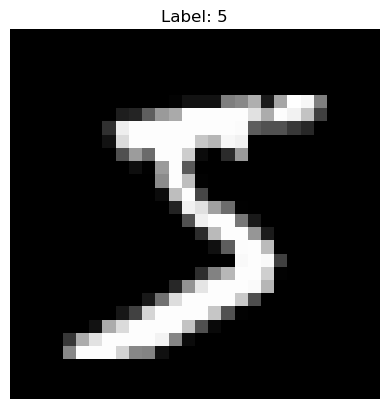

In [2]:
import matplotlib.pyplot as plt

# Fetch one item (an image and its label)
example_image, example_target = mnist_data_raw[0]
example_image, example_target

# Show in grayscale
plt.imshow(example_image, cmap='gray') 
# Display the label as the title
plt.title(f"Label: {example_target}")  
# Hide axes and show image
plt.axis('off') 
plt.show()

## Draw detailed pixel information

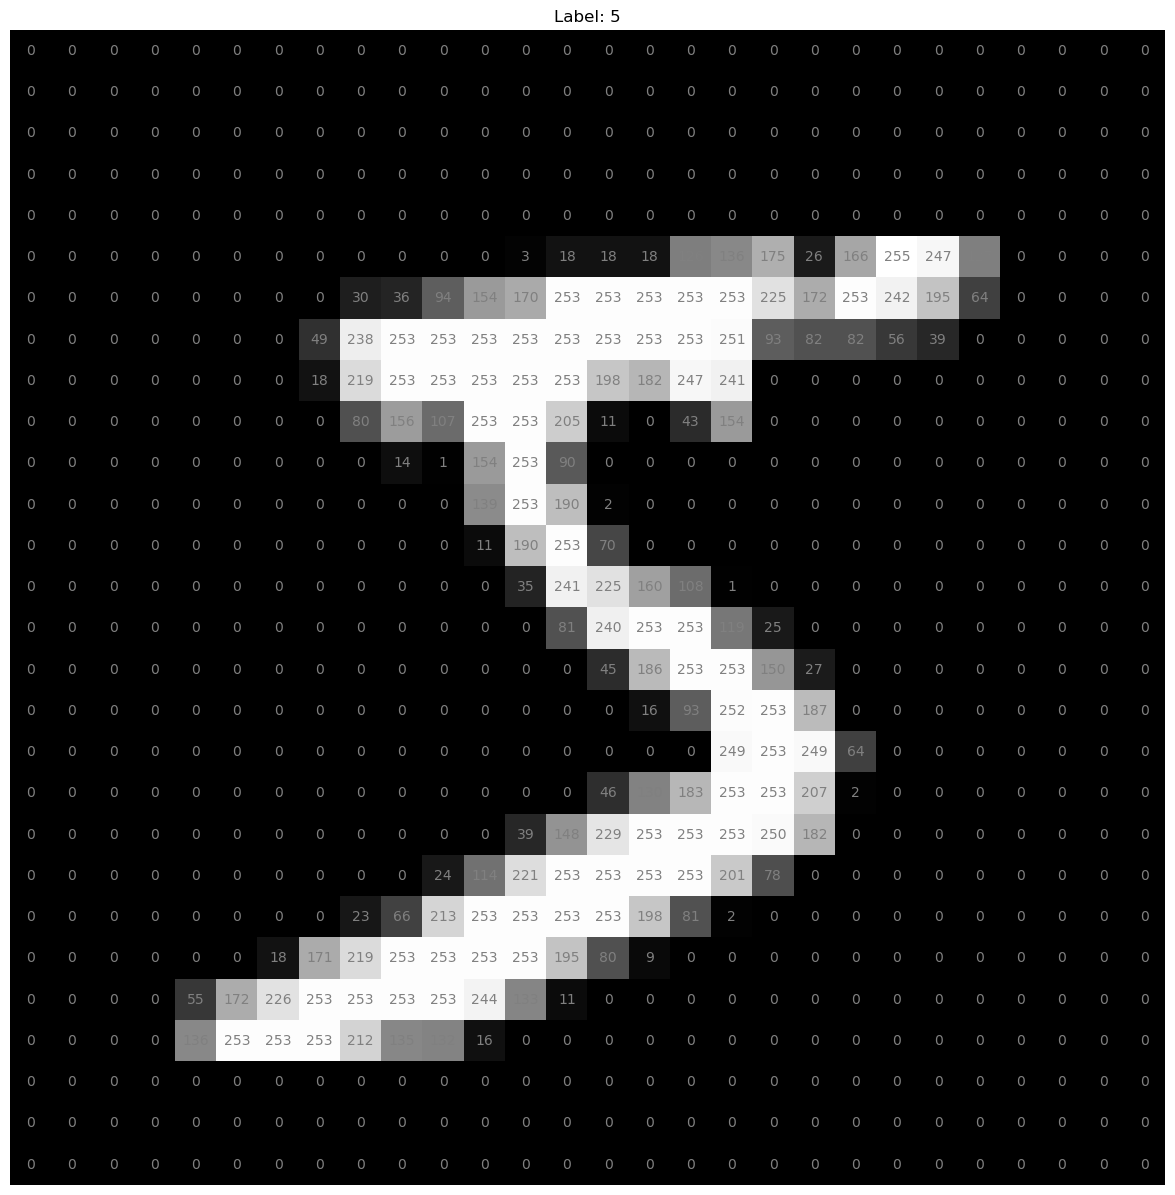

In [3]:
import numpy as np
# Convert the PIL image to a NumPy array for pixel access
example_array = np.array(example_image)

# Display the image using matplotlib
# figsize defines the size of the image in pixels.
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(example_array, cmap='gray')

# Annotate each pixel with its grayscale value
width, height = example_array.shape
for x in range(width):  # Loop over rows
    for y in range(height):  # Loop over columns
        ax.text(y, x, str(example_array[x, y]), fontsize=10, color='gray', ha='center', va='center')

plt.title(f"Label: {example_target}")
plt.axis('off')  # Hide axes for clarity
plt.show()

## Data preprocessing: normalization

In [4]:
import torchvision
import torch

# Ensure reproducibility
random_seed = 1
torch.manual_seed(random_seed)

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                              ])

* `torchvision.transforms.ToTensor()` 
  - Scales pixel values to the range `[0.0, 1.0]` if the input is a PIL image or a `uint8` NumPy array.
* `torchvision.transforms.Normalize((0.1307,), (0.3081,))`
  - **Purpose**: Normalizes the pixel values to have a mean of `0` and a standard deviation of `1`.
  - Normalization helps models converge faster during training and can improve performance.
- **How It Works**:
  - The formula for normalization is:

    $$
    \text{normalized\_value} = \frac{\text{original\_value} - \mu}{\sigma}
    $$

    where $\mu$ is the mean, and $\sigma$ is the standard deviation.

  - In this case:
    - Mean $\mu = 0.1307$
    - Standard Deviation $\sigma = 0.3081$
    - The transformed image values will be normalized and distributed around 0, with values generally between −0.5 and 3.

In [5]:
from torchvision import datasets, transforms

batch_size_train = 64
batch_size_test = 1000

# Load the MNIST dataset (training set)
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('mnist-data/', 
                             train=True, 
                             download=True,
                             transform=transform_mnist),
    batch_size=batch_size_train, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('mnist-data/', 
                             train=False, 
                             download=True,
                             transform=transform_mnist),
    batch_size=batch_size_test, 
    shuffle=True)

import os
# List all files in the current directory
files = os.listdir('./mnist-data/MNIST/raw')
print(files)

['train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte', 'train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte', 't10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte']


| File Name                   | Content            | Purpose                                   |
|-----------------------------|--------------------|-------------------------------------------|
| `train-images-idx3-ubyte`   | Training images    | 60,000 training images (28x28 pixels).   |
| `t10k-images-idx3-ubyte`    | Test images        | 10,000 test images (28x28 pixels).       |
| `train-labels-idx1-ubyte`   | Training labels    | Labels for the 60,000 training images.   |
| `t10k-labels-idx1-ubyte`    | Test labels        | Labels for the 10,000 test images.       |
| `*.gz` files                | Compressed files   | Compressed versions of the above files.  |


## Plot a few example images

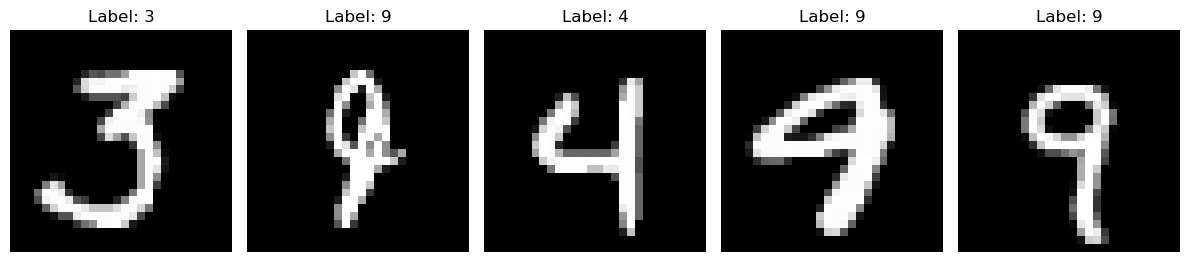

In [6]:
# Fetch one item (an image and its label)
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.imshow(example_data[i][0], cmap='gray')
    ax.set_title(f"Label: {example_targets[i].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [7]:
example_data.shape

torch.Size([1000, 1, 28, 28])

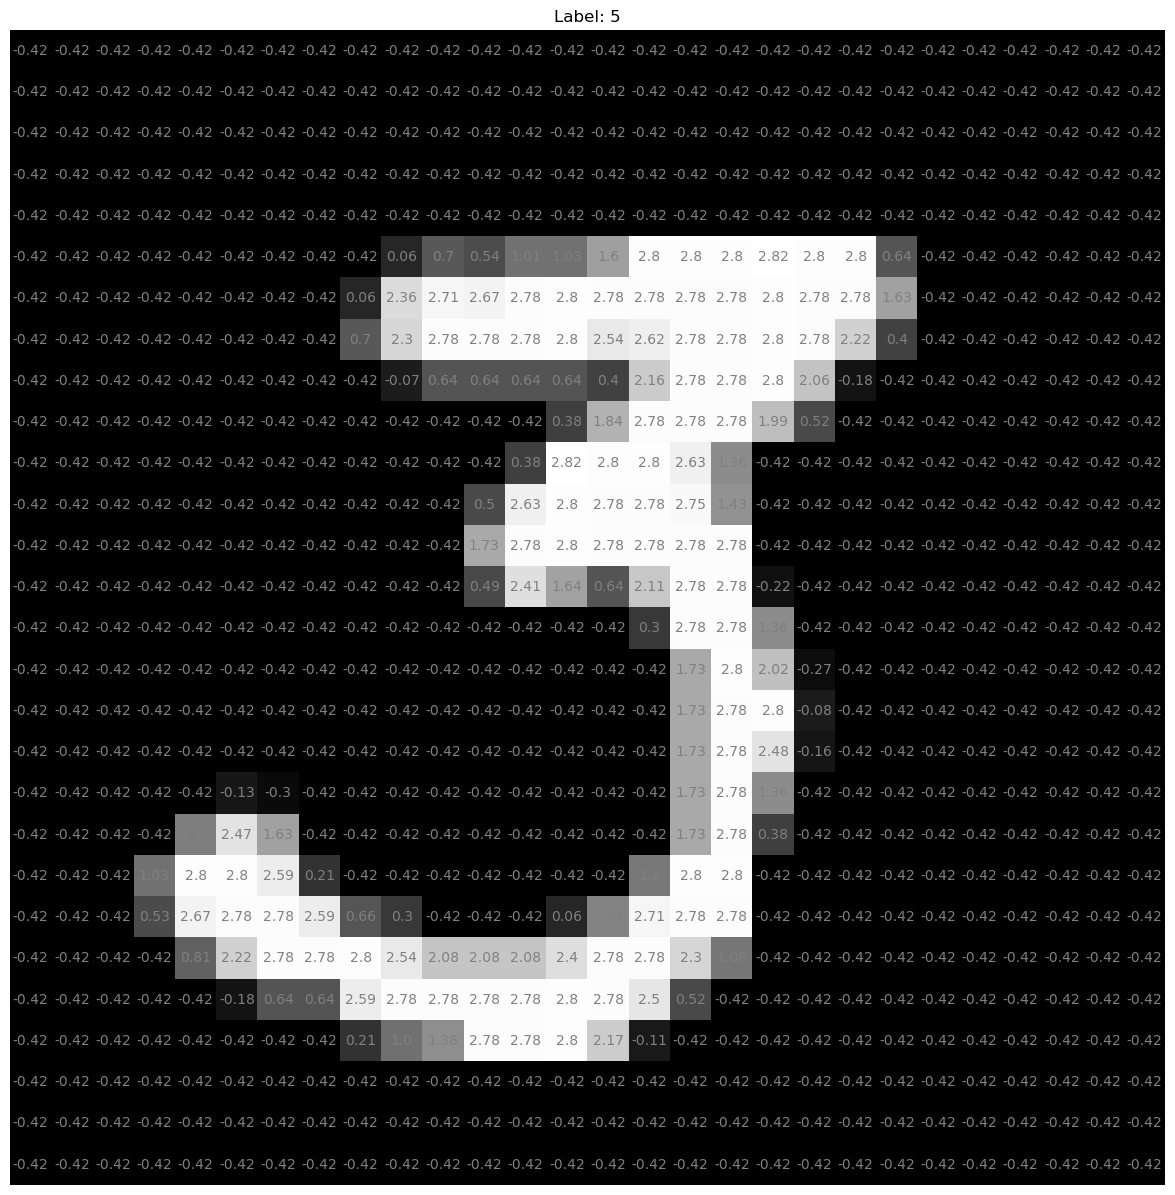

In [8]:
# Convert the PIL image to a NumPy array for pixel access
example_array = example_data[0][0].numpy()

# Display the image using matplotlib
# figsize defines the size of the image in pixels.
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(example_array, cmap='gray')

# Annotate each pixel with its grayscale value
width, height = example_array.shape
for x in range(width):  # Loop over rows
    for y in range(height):  # Loop over columns
        ax.text(y, x, str(round(example_array[x, y], 2)), fontsize=10, color='gray', ha='center', va='center')

plt.title(f"Label: {example_target}")
plt.axis('off')  # Hide axes for clarity
plt.show()

## Convolutional Neuronal Network Design

![CNN Pipeline](imgs/cnn-design2.png)

## Building the Network in PyTorch

Now let's go ahead and build our network. We'll use two 2-D convolutional layers followed by two fully-connected (or linear) layers. As activation function we'll choose rectified linear units (ReLUs in short) and as a means of regularization we'll use two dropout layers. 

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# **Explanation of the PyTorch Network**

This PyTorch network, defined as the class `Net`, is a small convolutional neural network (CNN) suitable for image classification tasks. 

## **Input and Output**
- **Input:** 
  - A tensor with shape `[batch_size, 1, H, W]`, representing a batch of grayscale images with height `H` and width `W`.

- **Output:** 
  - A tensor with shape `[batch_size, 10]`, where each element is the log-probability of one of the 10 classes.
---

## **`__init__` Method (Defining Layers):**

- `self.conv1`: A convolutional layer with:
  - **1 input channel** (e.g., grayscale images).
  - **10 output channels** (number of filters).
  - **Kernel size** of 5x5.
  
- `self.conv2`: A second convolutional layer with:
  - **10 input channels** (output of `conv1`).
  - **20 output channels** (number of filters).
  - **Kernel size** of 5x5.
  
- `self.conv2_drop`: A dropout layer for regularization, applied after the second convolution.
- `self.fc1`: A fully connected (dense) layer with:
  - **320 input features**.
  - **50 output features**.
  
- `self.fc2`: Another fully connected layer with:
  - **50 input features**.
  - **10 output features** (corresponding to the number of classes in the classification task).

---

## **`forward` Method (Defining the Flow of Data):**

This method defines how input data flows through the network:

1. **First Convolutional Layer:**
   - Pass input `x` through `conv1`.
   - Apply **ReLU activation**.
   - Perform **2D max-pooling** with a kernel size of 2.

2. **Second Convolutional Layer:**
   - Pass the output through `conv2`.
   - Apply **2D dropout** (`conv2_drop`) for regularization.
   - Apply **ReLU activation**.
   - Perform **2D max-pooling** with a kernel size of 2.

4. **Flattening:**
   - The 2D feature map output is reshaped into a 1D vector with **320 elements** (using `x.view(-1, 320)`).

5. **First Fully Connected Layer:**
   - Pass the flattened vector through `fc1`.
   - Apply **ReLU activation**.
   - Apply **dropout** for regularization (only during training).

6. **Second Fully Connected Layer:**
   - Pass the output through `fc2`.

7. **Output:**
   - Apply the **log-softmax** function to produce log-probabilities for the 10 output classes.

## **Details of Each Component**

1. **Convolutional Layers (`conv1` and `conv2`):**
   - Detect spatial features from the input images.
   - Each convolution uses a **5x5 filter**.
   - `conv1` learns **10 filters**, while `conv2` learns **20 filters**.

2. **Max Pooling (`F.max_pool2d`):**
   - Downsamples the feature maps by taking the maximum value in each **2x2 region**.
   - Reduces spatial dimensions, making computation more efficient and emphasizing dominant features.

3. **Dropout (`Dropout2d` and `F.dropout`):**
   - Prevents overfitting by randomly setting a fraction of the activations to zero during training.
   - training=self.training: self.training is a boolean attribute inherited from PyTorch's nn.Module. It is True when the model is in training mode (e.g., after calling model.train()). It is False when the model is in evaluation mode (e.g., after calling model.eval()).

4. **Fully Connected Layers (`fc1` and `fc2`):**
   - Combine features learned by convolutional layers for classification.

5. **Activation Functions (ReLU and Log-Softmax):**
   - **ReLU (rectified linear unit):** Introduces non-linearity, helping the network learn complex patterns.
      - While ReLU is not smooth, it is feasible and effective because:
         - It is computationally simple.
         - It avoids the vanishing gradient problem.
         - It introduces sparsity in activations.
         - Empirical results show that it performs well across many tasks. 
   - **Log-Softmax:** Outputs log-probabilities, commonly used with the negative log-likelihood loss.
---

### Dimensions
Input: Assumed to be a 28x28 grayscale image (1 channel).
* After conv1 (Conv2d(1,10,kernel_size=5)):
  - Output channels: 10.
  - Spatial size: 28−5+1=24 → 10x24x24.
* After first max pooling (kernel_size=2):
  - Reduces spatial dimensions by half → 10x12x12.
* After conv2 (Conv2d(10,20,kernel_size=5)):
  - Output channels: 20.
  - Spatial size: 12−5+1=8 → 20x8x8.
* After second max pooling (kernel_size=2):
-- Reduces spatial dimensions by half → 20x4x4.
* Total features: 
  - 20 channels
  - 20 channels×4×4=320.  

---

![CNN Pipeline](imgs/mnist-arc-details.png)

### **Key Points**

- The network is compact and efficient, suitable for small image datasets (like MNIST).
- Dropout and pooling layers enhance generalization and reduce the risk of overfitting.
- Fully connected layers and the log-softmax output are common for classification tasks.

## Building Training Pipeline

In [10]:
log_interval = 1000

# hyper parameters for the training
learning_rate = 0.01
momentum = 0.5
n_epochs = 10

network = MNISTNet()
optimizer = optim.SGD(network.parameters(), 
                      lr=learning_rate,
                      momentum=momentum)

* **learning_rate = 0.01**
  - Defines the learning rate for the optimizer, controlling the step size for weight updates during training.
* **momentum = 0.5**
  - Specifies the momentum parameter to smooth updates by considering the past gradients, helping to avoid local minima and accelerate convergence.
* **network = Net()** Creates an instance of the neural network model, Net. This should be a class defined elsewhere in the code that specifies the network architecture.

### Key Takeaway
This setup is essential for training the Net model, with SGD optimizing the weights based on gradient updates and momentum improving convergence efficiency.

## Training step

In [11]:
train_losses = []
train_counter = []

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    # Compute the negative log likelihood loss.
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
      
    # diagnostic trace
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

### Description 

- **optimizer.zero_grad()**: Resets gradients from the previous step.
- **output = network(data)**: Passes input data through the network to get predictions.
- **loss = F.nll_loss(output, target)**: Computes the negative log-likelihood loss.
- **loss.backward()**: Calculates gradients for backpropagation.
- **optimizer.step()**: Updates the model parameters using the optimizer

## Simulated Gradient Descent

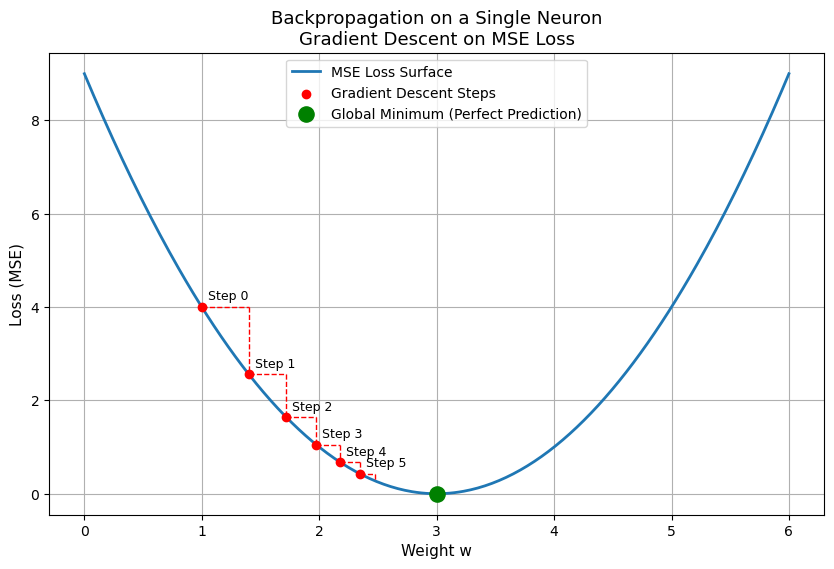

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Input and target
x = 1.0
true_value = 3.0

# Initial weight
w = 1.0
learning_rate = 0.1

# Track path
weights = [w]
losses = []

# Weight space for full loss curve
w_space = np.linspace(0, 6, 300)
loss_curve = (w_space * x - true_value) ** 2

# Training loop (true backprop)
for _ in range(6):
    # Forward pass
    prediction = w * x
    loss = (prediction - true_value) ** 2
    losses.append(loss)

    # Backpropagation
    gradient = 2 * (prediction - true_value) * x
    w -= learning_rate * gradient
    weights.append(w)

# Plot loss surface
plt.figure(figsize=(10, 6))
plt.plot(w_space, loss_curve, label="MSE Loss Surface", linewidth=2)

# Plot optimization steps
for i in range(len(weights) - 1):
    # Horizontal step: parameter update
    plt.plot(
        [weights[i], weights[i+1]],
        [losses[i], losses[i]],
        'r--',
        linewidth=1
    )

    # Vertical step: loss change
    new_loss = (weights[i+1] * x - true_value) ** 2
    plt.plot(
        [weights[i+1], weights[i+1]],
        [losses[i], new_loss],
        'r--',
        linewidth=1
    )

# Plot points
plt.scatter(weights[:-1], losses, color='red', zorder=5, label="Gradient Descent Steps")

# Annotate points
for i, (w_i, l_i) in enumerate(zip(weights[:-1], losses)):
    plt.text(w_i + 0.05, l_i + 0.15, f"Step {i}", fontsize=9)

# Mark global minimum
plt.scatter(
    [true_value],
    [0],
    color='green',
    s=120,
    zorder=6,
    label="Global Minimum (Perfect Prediction)"
)

# Labels and explanation
plt.xlabel("Weight w", fontsize=11)
plt.ylabel("Loss (MSE)", fontsize=11)
plt.title("Backpropagation on a Single Neuron\nGradient Descent on MSE Loss", fontsize=13)

plt.legend()
plt.grid(True)
plt.show()


## Test step

In [13]:
test_losses = []
test_counter = []
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


### Description 
- **output = network(data)**: Feeds input data into the model for predictions.
- **test_loss += F.nll_loss(...)**: Computes and accumulates the negative log-likelihood loss for the entire dataset (using sum over all samples).
- **pred = output.data.max(1, keepdim=True)[1]**: Determines the class with the highest probability for each sample.
- **correct += pred.eq(target.data.view_as(pred)).sum()**: Counts correctly predicted labels.

### Model in the loop

In [ ]:
print('Model performance before training')
# Calls the test() function before training begins to evaluate the model's initial performance on the test dataset (e.g., for a baseline).
test()
print('Start taining')
print()
# Loops through training and testing for a total of n_epochs epochs.
for epoch in range(0, n_epochs):
  # Calls the train() function, passing the current epoch number, to train the model for one complete epoch.  
  train(epoch)
  # After each epoch of training, the test() function is called to evaluate the model on the test dataset.
  test()

Model performance before training

Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Start taining

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.325928


### Performance over training

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(len(train_losses)),train_losses, label="train loss")
ax.plot(range(len(test_losses)),test_losses, label="test loss")
ax.set_xlabel("iteration")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))

ax.legend()
ax.grid()

## Take a look into model insight

In [ ]:
# Dummy input for visualization (1 grayscale image of size 28x28)
dummy_input = torch.randn(1, 1, 28, 28)

# Hook to store feature maps
feature_maps = {}

def hook_fn(module, input, output):
    feature_maps[module] = output

# Register hooks for conv1 and conv2
network.conv1.register_forward_hook(hook_fn)
network.conv2.register_forward_hook(hook_fn)

# Pass the dummy input through the network
_ = network(dummy_input)

# Visualize feature maps
def visualize_feature_maps(feature_maps, layer, num_filters=5):
    fm = feature_maps[layer][0]  # First image in the batch
    num_filters = min(num_filters, fm.size(0))  # Limit to available filters

    fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))
    for i in range(num_filters):
        axes[i].imshow(fm[i].detach().numpy(), cmap='gray')
        axes[i].set_title(f"Filter {i+1}")
        axes[i].axis('off')
    plt.show()

# Visualize feature maps for conv1 and conv2
print("Feature maps from conv1:")
visualize_feature_maps(feature_maps, network.conv1, num_filters=10)

print("Feature maps from conv2:")
visualize_feature_maps(feature_maps, network.conv2, num_filters=10)

# Create a dummy input
dummy_input = torch.randn(1, 1, 28, 28)  # Adjust based on your input dimensions

# Get the output
output = network(dummy_input)


## Usage of trained model

In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Load the pre-trained model (make sure the path is correct)
model = MNISTNet()
model.load_state_dict(torch.load('model.pth'))
model.eval()  # Set to evaluation mode

# Preprocessing transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.Resize((28, 28)),                  # Resize to 28x28
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize((0.1307,), (0.3081,))    # Normalize pixel values
])

def process_and_predict(image_path, model):
    """
    Process a PNG image, evaluate it with the model, and return the predicted digit and probabilities.
    """
    # Extract true label from filename (assuming filename format is `<label>.png`)
    true_label = os.path.basename(image_path).split('.')[0]

    # Load and preprocess the image
    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Evaluate using the model
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = F.softmax(output, dim=1).squeeze().tolist()  # Convert logits to probabilities
        probabilities = [round(p, 3) for p in probabilities]
        predicted_label = output.argmax(dim=1).item()

    return img, true_label, predicted_label, probabilities


def evaluate_images_in_directory(directory, model):
    """
    Evaluate all images in a directory and display them with predictions.
    """
    for image_file in os.listdir(directory):
        if image_file.endswith(".png"):  # Process only PNG files
            image_path = os.path.join(directory, image_file)
            img, true_label, predicted_label, probabilities = process_and_predict(image_path, model)
            #formatted_probabilities = [f"{p:.3f}" for p in probabilities]  
            formatted_probabilities = [f"{i}: {p:.3f}" for i, p in enumerate(probabilities)]# Format to 3 decimal places

            # Display the image with the true label, prediction, and probabilities
            plt.imshow(img, cmap="gray")
            plt.title(f"True: {true_label}, Predicted: {predicted_label}\n"
                      f"Probabilities: {formatted_probabilities}")
            plt.axis("off")
            plt.show()

# Directory containing test PNG images
test_directory = "./mnist-handwritten"

# Evaluate all images in the directory
evaluate_images_in_directory(test_directory, model)
